# Introduction

In this example, we shall try to learn an abitrary $8 \times 8$ 
unitary matrix $U$, via gradient descent. We shall start with a 
random parametrized unitary matrix $U(\vec{\theta}, \vec{\phi}, \vec{\omega})$.

Parametrized unitaries in `qgrad` are available via `Unitary` class
with  $\vec{\theta}, \vec{\phi}, \vec{\omega}$ as parameter
vectors with $\vec{\theta}, \vec{\phi}$ being $\frac{(N) (N-1)}{2}$
dimensional and $\vec{\omega})$ being $N$-dimensional.


Here the input dataset consists of $8 \times 1$ random 
kets, call them
$| \psi_{i} \rangle$ and output dataset is the action of the 
target unitary $U$ on these kets, $U |\psi_{i} \rangle$. The 
maximum value of $i$ is $80$, meaning that we merely use 80
data points (kets in this case) to efficiently learn the 
target unitary, $U$.


This tutorial is different from the 
[Qubit Rotation](https://github.com/qgrad/qgrad/blob/master/examples/QubitRotation.py),
in that it learns the unitary matrix to not only take a fixed _specific_
state to another _fixed_ state. Here the unitary
$U( \vec{\theta}, \vec{\phi}, \vec{\omega})$ is learnt to evolve _any_ same
dimensional ket as the target unitary, $U$ would evolve it. 


**Note**: Another version of this tutorial is implemented 
without `qgrad` that uses the parametrization used in 
[Seth Lloyd and Reevu Maity, 2020](https://arxiv.org/pdf/1901.03431.pdf)
and verifies the part of the results of that paper. This tutorial 
shows similar results, only with different unitary paramterization
$U(\vec{\theta}, \vec{\phi}, \vec{\omega})$  since the
parametrization used in the original paper 
uses hamiltonians 
in the powers of exponents, whose autodifferentiation is
not currently supported in JAX. For further reading 
on this autodifferentiation incompatibility and unitary learning, 
please refer to companion blogs 
[here](https://araza6.github.io/posts/hamiltonian-differentiation/)
and [here](https://araza6.github.io/posts/unitary-learning/) 


In [23]:
import jax.numpy as jnp
from jax import grad
from jax.experimental import optimizers
from jax.random import PRNGKey, uniform

import numpy as onp

#Visualization
import matplotlib.pyplot as plt 

from qgrad.qgrad_qutip import fidelity, Unitary

from qutip import rand_ket # only to make the dataset

from scipy.stats import unitary_group

In [12]:
def make_dataset(m, d):
    """Prepares a dataset of input and output 
    kets to be used for training.
    
    Args:
        m (int): Number of data points, 80% of 
            which would be used for training
        d (int): Dimension of a (square) unitary
            matrix to be approximated
    
    Returns:
        tuple: tuple of lists containing (JAX Device
            Arrays of) input and output kets 
            respectively
    """
    ket_input = []
    ket_output = []
    for i in range(m):
        ket_input.append(jnp.array(rand_ket(d, seed=300).full()))
        #Output data -- action of unitary on a ket states
        ket_output.append(jnp.dot(tar_unitr, ket_input[i]))  
    
    return (ket_input, ket_output)

m = 100 # number of training data points
N = 8 # Dimension of the unitary to be learnt
train_len = int(m * 0.8)
# tar_unitr gives a different unitary each time
tar_unitr = jnp.asarray(unitary_group.rvs(N))
ket_input, ket_output = make_dataset(m, N)

# Cost Function

We use the same cost function as the authors
[Seth Lloyd and Reevu Maity, 2020](https://arxiv.org/pdf/1901.03431.pdf)
define 

$\begin{equation} \label{err_ps}
         E = 1 - (\frac{1}{M})\sum_{i} \langle \psi_{i}|U^{\dagger} U(\vec{\theta}, \vec{\phi}, \vec{\omega})|\psi_{i}\rangle
 \end{equation}$, 

where $ |\psi_{i} \rangle$ is the training (or testing) 
data points -- in this case, kets, $U$ and 
$U(\vec{\theta}, \vec{\phi}, \vec{\omega})$ are the target and
parameterized unitaries respectively and $M$ is the total
number of training data points, which in our example is
$80$


In [13]:
def cost(params, inputs, outputs):
    r"""Calculates the cost on the whole 
        training dataset.
    
    Args:
        params (obj:`jnp.ndarray`): parameter vectors 
            :math:`\vec{\theta}, \vec{\phi}, 
            \vec{\omega}`
        inputs (obj:`jnp.ndarray`): input kets 
            :math:`|\psi_{i} \rangle`in the dataset
        outputs (obj:`jnp.ndarray`): output kets 
            :math:`U(\vec{\theta}, \vec{\phi}, 
            \vec{\omega})|ket_{input} \rangle` 
            in the dataset
    
    Returns:
        float: Cost (evaluated on the entire dataset)
            of parametrizing :math:`U(\vec{\theta}, 
            \vec{\phi}, \vec{\omega})` with `params`                  
    """
    loss = 0.0
    thetas, phis, omegas = params
    unitary = Unitary(N)(thetas, phis, omegas)
    for k in range(train_len):
        pred = jnp.dot(unitary, inputs[k]) 
        loss += jnp.absolute(jnp.real(jnp.dot(outputs[k].conjugate().T, pred)))

    loss = 1 - (1 / train_len) * loss
    return loss[0][0]

In [14]:
def test_score(params, inputs, outputs):
    """Calculates the average fidelity between the
        predicted and output kets for given parameters
        (averaged over the whole training set).
       
       Args:
           params (obj:`jnp.ndarray`): parameter vectors 
               :math:`\vec{\theta}, \vec{\phi}, \vec{\omega}`
           inputs (obj:`jnp.ndarray`): input kets 
               :math:`|\psi_{l} \rangle`in the dataset 
           outputs (obj:`jnp.ndarray`): output kets 
               :math:`U(\vec{t}, \vec{\tau})|ket_{input} \rangle`
               in the dataset
           
       Returns:
           float: fidelity between :math:`U(\vec{\theta}, 
               \vec{\phi}, \vec{\omega})|ket_{input} \rangle`
               and the output (label) kets for given `params`
            
       """
    fidel = 0
    thetas, phis, omegas = params
    unitary = Unitary(N)(thetas, phis, omegas)
    for i in range(train_len):
        pred = jnp.dot(unitary, inputs[i])
        step_fidel = fidelity(pred, outputs[i])
        fidel += step_fidel
        
    return (fidel / train_len)[0][0]

In [26]:
# Fixed PRNGKeys to pick the same starting params
params = uniform(PRNGKey(0), (N**2, ), 
                        minval=0.0, maxval=2 * jnp.pi)
thetas = params[:N * (N-1) // 2]
phis = params[N * (N - 1) // 2 : N * (N - 1)]
omegas = params[N * (N - 1):]
params = [thetas, phis, omegas]

opt_init, opt_update, get_params = optimizers.adam(step_size=1e-1)
opt_state = opt_init(params)

def step(i, opt_state, opt_update):
    params = get_params(opt_state)
    g = grad(cost)(params, ket_input, ket_output)
    return opt_update(i, g, opt_state)

epochs = 40

loss_hist = []
params_hist = []
fidel_hist = []

for i in range(epochs):
    opt_state = step(i, opt_state, opt_update)
    params = get_params(opt_state)
    params_hist.append(params)
    loss = cost(params, ket_input, ket_output)
    loss_hist.append(loss)
    avg_fidel = test_score(params, ket_input, ket_output)
    fidel_hist.append(avg_fidel)
    progress = [i+1, loss, avg_fidel]
    if (i % 10 == 9):
        print("Epoch: {:2f} | Loss: {:3f} | Fidelity: {:3f}".
              format(*jnp.asarray(progress)))

Epoch: 10.000000 | Loss: 0.061839 | Fidelity: 0.888217
Epoch: 20.000000 | Loss: 0.014260 | Fidelity: 0.975306
Epoch: 30.000000 | Loss: 0.006706 | Fidelity: 0.986648
Epoch: 40.000000 | Loss: 0.002017 | Fidelity: 0.995984


# Analyzing Learning Routine

We see that we _efficiently_ (with $ \sim 99 \%$ 
fidelity) reconstruct the target unitary $U$ starting 
from a random initial guess. We merely use $80$
examples for training, and in $40$ crude gradient
steps, we almost perfectly approximate the target
unitary, $U$. Below is a plot of how fidelity increases
and loss gets down to zero in the training schedule.

In the graph below, $M$ represents
the total size of the train set, $\psi_{label}$ 
represents the resulting (or the output)
ket evolved under the target unitary, 
$U$ as $U |\psi_{i} \rangle$ and 
$\psi_{pred}$ represents the ket $\psi_{i}$
evolved under 
$U(\vec{\theta}, \vec{\phi}, \vec{\omega})$
as $ U(\vec{\theta}, \vec{\phi}, \vec{\omega}) | \psi_{i} \rangle$.

Each marker on the graph is the fidelity between 
the predicted and the target/label kets averaged over the
whole train set and the cost on whole training set
respectively.

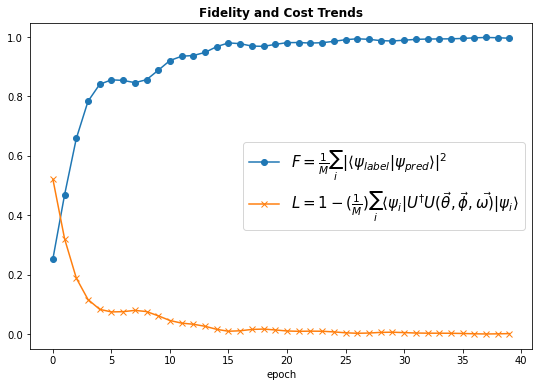

In [27]:
plt.figure(figsize=(9, 6))

plt.plot(fidel_hist, marker = 'o', 
         label=r"$F = \frac{1}{M}\sum_{i}| \langle \psi_{label} | \psi_{pred} \rangle |^2$")

plt.plot(loss_hist, marker = 'x',
        label=r'''$L = 1 - (\frac{1}{M})\sum_{i}\langle \psi_{i} | U ^{\dagger} U( \vec{\theta}, \vec{\phi}, \vec{\omega)} | \psi_{i} \rangle$''')

plt.title("Fidelity and Cost Trends", fontweight = "bold")
plt.legend(["Fidelity","Loss"])
plt.xlabel("epoch")
plt.legend(loc=0, prop = {'size': 15})

# Testing on unseen kets

We reserved the last $20$ kets for testing. Now we shall apply
our learned unitary matrix, call it 
$U_{opt}(\vec{\theta}, \vec{\phi}, \vec{\omega})$
to the unseen kets and measure the fidelity of the evolved ket
under $U_{opt}(\vec{\theta}, \vec{\phi}, \vec{\omega})$ 
with those that evolved under the target unitary, $U$.

In [22]:
theta_opt, phi_opt, omega_opt = params_hist[-1]
opt_unitary = Unitary(N)(theta_opt, phi_opt, omega_opt)
fidel = []
for i in range(train_len, m): # unseen data
    pred = jnp.dot(opt_unitary, ket_input[i])
    fidel.append(fidelity(pred, ket_output[i])[0][0])
fidel

[DeviceArray(0.98841643, dtype=float32),
 DeviceArray(0.98841643, dtype=float32),
 DeviceArray(0.98841643, dtype=float32),
 DeviceArray(0.98841643, dtype=float32),
 DeviceArray(0.98841643, dtype=float32),
 DeviceArray(0.98841643, dtype=float32),
 DeviceArray(0.98841643, dtype=float32),
 DeviceArray(0.98841643, dtype=float32),
 DeviceArray(0.98841643, dtype=float32),
 DeviceArray(0.98841643, dtype=float32),
 DeviceArray(0.98841643, dtype=float32),
 DeviceArray(0.98841643, dtype=float32),
 DeviceArray(0.98841643, dtype=float32),
 DeviceArray(0.98841643, dtype=float32),
 DeviceArray(0.98841643, dtype=float32),
 DeviceArray(0.98841643, dtype=float32),
 DeviceArray(0.98841643, dtype=float32),
 DeviceArray(0.98841643, dtype=float32),
 DeviceArray(0.98841643, dtype=float32),
 DeviceArray(0.98841643, dtype=float32)]

# Conclusion

We see that the testing fidelity is
$\sim 98 \%$, as opposed to training 
fidelity $\sim 99 \%$. One would expect
this since drop as the unitary now
acts on unseen data. We, however, note
that we generalize well with 
$\sim 98 \%$ accuracy, if you will. 

This learnt unitary
$U_{opt}(\vec{\theta}, \vec{\phi}, \vec{\omega})$
can now be used to emulate the original 
target unitary, $U$, for more general 
datasets as well.

# References
1. Lloyd, Seth, and Reevu Maity. "Efficient implementation of unitary transformations." arXiv preprint arXiv:1901.03431 (2019).